# Imports

In [99]:
from model_builder import ModelBuilder
import random
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import colorsys
from sklearn.decomposition import PCA
from itertools import cycle
plt.rcParams["font.family"] = "Times New Roman"
import warnings
warnings.filterwarnings("ignore")

In [2]:
with open("config.json", "rb") as json_file:
    config = json.load(json_file)
config

{'becker': {'filename': 'beckerestimation_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'mean_pre_discussion_error',
   'mean_post_discussion_error',
   'mean_pre_discussion_error_pct',
   'mean_post_discussion_error_pct',
   'question',
   'chatrooms',
   'trial_indx']},
 'csop': {'filename': 'csop_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'batch_num',
   'round_num',
   'round_index',
   'task_index',
   'complexity',
   'type',
   'social_perceptiveness',
   'skill',
   'normalized_score',
   'score',
   'duration',
   'efficiency']},
 'csopII': {'filename': 'csopII_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'batch_num',
   'vis_img',
   'int_verb',
   'ort_img',
   'rep_man',
   'soc_pers',
   'team_size',
   'difficulty',
   'score',
   'duration',
   'efficiency',
   'timestamp']},
 'dat': {'filename': 'DAT_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'b

# Repeated k-Fold Cross Validation
For each model, fit it k (=10) times, and track all metrics, as well as interpretability, across all the repeats.
This gets us a less noisy estimate at our models' performance.

In [3]:
def repeated_kfold_cv(model, k = 10, seed = 19104):

    """
    Parameters:
    - model: The model we are doing k-fold CV for
    - k: the number of fols (defaults to 10)
    - seed: the random seed (defaults to 19104)

    @returns the following, pouplated with data from the k0=-fold CV:
    - train_metrics: a dataframe to store all the training metrics
    - test_metrics: a dataframe to store all the test set metrics (we will universally use a 80-20 train-test split)
    - shap_df: a dataframe to store the Shapley value summaries for each fold
    - shap_correlation_df: a dataframe to store how the Shapley values correlate with feature values for each fold
    """

    # Repeated k-fold cross-validation
    random.seed(seed) # set seed for reproducibility
    random_states_list = [random.randint(100, 1000000) for _ in range(k)] # create a bunch of different random states

    # Store metrics --- R^2, MAE, MSE
    metrics = ['r2', 'mae', 'mse', 'rmse']
    train_metrics = pd.DataFrame(columns=metrics)
    test_metrics = pd.DataFrame(columns=metrics)

    for i in range(len(random_states_list)):
        # store the model metrics for each iteration
        metrics = model.evaluate_model(model.baseline_model, val_size = 0.2, test_size = None, random_state = random_states_list[i], visualize_model = False)
        train_metrics = train_metrics.append(metrics['train'], ignore_index=True)
        test_metrics = test_metrics.append(metrics['val'], ignore_index=True)
    
        # store the shap summary for each iteration

        try:     
            shap_summary = model.shap_summary
            shap_df = pd.merge(shap_df, shap_summary[['feature', 'shap']], on='feature')
            shap_df.rename(columns={'shap': f'shap_{i+1}'}, inplace=True)
            shap_correlation_df = pd.merge(shap_correlation_df, shap_summary[['feature', 'correlation_btw_shap_and_feature_value']], on='feature')
            shap_correlation_df.rename(columns={'correlation_btw_shap_and_feature_value': f'cor_{i+1}'}, inplace=True)
        except NameError:
            # we haven't defined these yet; we're in the first iteration!
            # we have to do this becaus model.X does not show up until after the first case when evaluate_model is called
            shap_df = pd.DataFrame({'feature': model.X.columns})
            shap_correlation_df = pd.DataFrame({'feature': model.X.columns})

            shap_summary = model.shap_summary
            shap_df = pd.merge(shap_df, shap_summary[['feature', 'shap']], on='feature')
            shap_df.rename(columns={'shap': f'shap_{i+1}'}, inplace=True)
            shap_correlation_df = pd.merge(shap_correlation_df, shap_summary[['feature', 'correlation_btw_shap_and_feature_value']], on='feature')
            shap_correlation_df.rename(columns={'correlation_btw_shap_and_feature_value': f'cor_{i+1}'}, inplace=True)


    shap_df.set_index('feature', inplace=True)
    shap_correlation_df.set_index('feature', inplace=True)

    return(shap_df, shap_correlation_df, train_metrics, test_metrics)

In [4]:
def get_repeated_kfold_cv_summary(shap_df, shap_correlation_df, train_metrics, test_metrics):
    """
    Get the means of the repeated k-fold cross validation across all relevant metrics.
    """
    shap_means = shap_df.mean(axis=1).sort_values(ascending = False)
    shap_cor_means = shap_correlation_df.mean(axis=1).reindex(index = shap_means.index)
    train_means = train_metrics.mean()
    test_means = test_metrics.mean()

    return(shap_means, shap_cor_means, train_means, test_means)

In [5]:
time_points = ["25%", "50%", "75%", "100%"]

In [6]:
NUM_TOP_FEATURES = 5

In [7]:
def plot_important_features_over_time(merged_df, color_palette, title="Top Feature Importance Over Time", filename="./figures/feature_importance.png"):
    # Transpose the DataFrame and sort by each time point
    top_features = merged_df.apply(lambda x: x.nlargest(NUM_TOP_FEATURES))

    non_na_feature = top_features.dropna()
    na_feature = top_features.loc[~top_features.index.isin(top_features.dropna().index)].fillna(0)

    # Plot a line chart to show how the top feature values change over time
    if not non_na_feature.empty and not na_feature.empty:
        ax = non_na_feature.T.plot(kind='line', marker='o', linewidth=3, color=color_palette)
        na_feature.T.plot(kind='line', marker='o', linestyle='--', linewidth=3, ax=ax, color=color_palette)  # Use the same axis for dashed lines
    elif non_na_feature.empty:
        ax = na_feature.T.plot(kind='line', marker='o', linestyle='--', linewidth=3, color=color_palette)
    elif na_feature.empty:
        ax = non_na_feature.T.plot(kind='line', marker='o', linewidth=3, color=color_palette)

    plt.ylabel('Importance (SHAP value)', size=14)
    plt.xlabel('Percent of Chat Messages (Chronological)', size=14)
    plt.title(title, fontsize=18, fontweight="bold")
    plt.xticks(range(len(time_points)), time_points, fontsize=14)

    # Update legend with custom color mapping
    legend_labels = ax.get_legend().get_texts()
    for label in legend_labels:
        feature_name = label.get_text()

    plt.legend(loc='upper left', fontsize=12, bbox_to_anchor=(1.05, 1), bbox_transform=ax.transAxes)

    plt.savefig(filename, dpi=1200, bbox_inches='tight')
    plt.show()

In [8]:
def plot_r2_and_mse_over_time(metrics, title):
    # Transpose the data for plotting
    transposed_data = metrics.T
    fig, ax1 = plt.subplots()

    plt.style.use({"figure.facecolor": "white", "axes.facecolor": "white"})

    # Create the left y-axis for R^2
    ax1.set_ylabel("R^2", fontsize=14)
    ax1.plot(time_points, transposed_data["r2"], label="R^2", color="cadetblue", marker="o", linewidth=3)
    ax1.tick_params(axis="y", size=14)

    # Create the right y-axis for MSE
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel("MSE", fontsize=14)
    ax2.plot(time_points, transposed_data["mse"], label="MSE", color="mediumorchid", marker="o", linewidth=3)
    ax2.tick_params(axis="y", size=14)

    #x-axis font size
    ax1.tick_params(axis="x", labelsize=14)
    ax1.set_xlabel('Percent of Chat Messages (Chronological)', size=14)

    # Combine the legends for both lines
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc="upper left")

    # Adjust layout
    plt.title(title, fontweight="bold", fontsize=18)
    plt.tight_layout()
    plt.show()

# Per-Task Baseline Models
This notebook contains the _baseline models_ for each task. This allows us to get a quick understanding of the predictive features for each task (separately).

The lists of models are:

(1) Random Forests for each task:
- Jury
- CSOP Blended (across two datasets)
- CSOP Train -> CSOP II split
- DAT
- Estimation (Becker + Gurcay datasets, blended)

(2) Early Cut-off Models (Train model only on the first X% of the messages, so that we avoid issues where the final stages of the discussion reveal the outcome)
- 25% (all datasets)
- 50% (all datasets)
- 75% (all datasets)


# Jury

### Full Data (100)%

In [9]:
# Define the basic model
juries_model = ModelBuilder(dataset_names = ["juries"])
juries_model.select_target(target=["majority_pct"])
juries_model.define_model(model_type = 'rf')

In [10]:
# Call the Repeated k-Fold CV
jury_shap, jury_shap_cor, jury_train_metrics, jury_test_metrics = repeated_kfold_cv(juries_model)
jury_shap_means, jury_shap_cor_means, jury_train_means, jury_test_means = get_repeated_kfold_cv_summary(jury_shap, jury_shap_cor, jury_train_metrics, jury_test_metrics)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done


### 75% Data

In [11]:
juries_model75 = ModelBuilder(dataset_names = ["juries"], output_dir = '../output/first_75/')
juries_model75.select_target(target=["majority_pct"])
juries_model75.define_model(model_type = 'rf')

In [12]:
jury_shap75, jury_shap_cor75, jury_train_metrics75, jury_test_metrics75 = repeated_kfold_cv(juries_model75)
jury_shap_means75, jury_shap_cor_means75, jury_train_means75, jury_test_means75 = get_repeated_kfold_cv_summary(jury_shap75, jury_shap_cor75, jury_train_metrics75, jury_test_metrics75)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done


### 50% Data

In [13]:
juries_model50 = ModelBuilder(dataset_names = ["juries"], output_dir = '../output/first_50/')
juries_model50.select_target(target=["majority_pct"])
juries_model50.define_model(model_type = 'rf')

In [14]:
jury_shap50, jury_shap_cor50, jury_train_metrics50, jury_test_metrics50 = repeated_kfold_cv(juries_model50)
jury_shap_means50, jury_shap_cor_means50, jury_train_means50, jury_test_means50 = get_repeated_kfold_cv_summary(jury_shap50, jury_shap_cor50, jury_train_metrics50, jury_test_metrics50)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done


### 25% of Data

In [15]:
juries_model25 = ModelBuilder(dataset_names = ["juries"], output_dir = '../output/first_25/')
juries_model25.select_target(target=["majority_pct"])
juries_model25.define_model(model_type = 'rf')

In [16]:
jury_shap25, jury_shap_cor25, jury_train_metrics25, jury_test_metrics25 = repeated_kfold_cv(juries_model25)
jury_shap_means25, jury_shap_cor_means25, jury_train_means25, jury_test_means25 = get_repeated_kfold_cv_summary(jury_shap25, jury_shap_cor25, jury_train_metrics25, jury_test_metrics25)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done


### Combine Results for Juries

In [17]:
pd.concat([jury_shap_cor_means25, jury_shap_cor_means50, jury_shap_cor_means75, jury_shap_cor_means], keys = time_points, axis=1).head(10)

,25%,50%,75%,100%
feature,,,,
average_user_sum_cognitive_mech,-0.738689,-0.737273,-0.744374,-0.740060
average_user_sum_positivity_zscore_chats,0.697781,0.676703,0.712002,0.685833
average_user_sum_verbs,-0.690189,-0.692960,-0.690535,-0.690277
min_user_sum_positivity_zscore_chats,0.801583,0.806051,0.801004,0.800535
average_user_sum_discrepancies,-0.528420,-0.478708,-0.516270,-0.480623
average_user_sum_1st_person_pl.,0.737104,0.725156,0.731950,0.722761
average_user_sum_auxiliary_verbs,-0.667579,-0.644126,-0.650176,-0.650430
stdev_past_tense,-0.819332,NaN,NaN,NaN
average_user_sum_first_person_plural,0.775844,0.770963,0.743776,0.586731


### Make Feature Color Dictionary

In [18]:
NUM_COLORS = 10011*len(juries_model.X.index)

In [19]:
def generate_color(feature_name):
    hashed = hash(feature_name) % NUM_COLORS
    hue = hashed / 1000.0
    saturation = (hashed % NUM_COLORS) / NUM_COLORS  # Vary the saturation within a range (0.7 to 1.0)
    value = 0.8
    color_rgb = colorsys.hsv_to_rgb(hue, saturation, value)
    return color_rgb

# Create a color mapping dictionary that is consistent
color_mapping = {feature_name: generate_color(feature_name) for feature_name in juries_model.X.columns}


In [20]:
merged_df = pd.concat([jury_shap_means25, jury_shap_means50, jury_shap_means75, jury_shap_means], keys = time_points, axis=1)

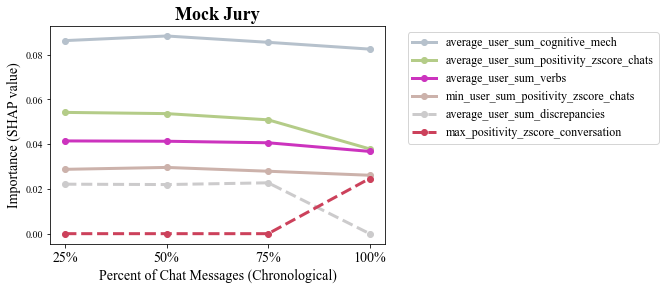

In [21]:
plot_important_features_over_time(merged_df, color_mapping, "Mock Jury", "./figures/jury_features.svg")

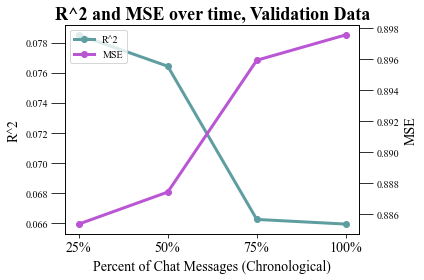

In [22]:
test_metrics = pd.concat([jury_test_means25, jury_test_means50, jury_test_means75, jury_test_means], keys = time_points, axis=1)
plot_r2_and_mse_over_time(test_metrics, "R^2 and MSE over time, Validation Data")

In [23]:
# look at direction of impact
pd.concat([jury_shap_cor_means25, jury_shap_cor_means50, jury_shap_cor_means75, jury_shap_cor_means], keys = time_points, axis=1).head(10)

,25%,50%,75%,100%
feature,,,,
average_user_sum_cognitive_mech,-0.738689,-0.737273,-0.744374,-0.740060
average_user_sum_positivity_zscore_chats,0.697781,0.676703,0.712002,0.685833
average_user_sum_verbs,-0.690189,-0.692960,-0.690535,-0.690277
min_user_sum_positivity_zscore_chats,0.801583,0.806051,0.801004,0.800535
average_user_sum_discrepancies,-0.528420,-0.478708,-0.516270,-0.480623
average_user_sum_1st_person_pl.,0.737104,0.725156,0.731950,0.722761
average_user_sum_auxiliary_verbs,-0.667579,-0.644126,-0.650176,-0.650430
stdev_past_tense,-0.819332,NaN,NaN,NaN
average_user_sum_first_person_plural,0.775844,0.770963,0.743776,0.586731


# CSOP (blended)

### Full Data (100%)

In [24]:
csop_blended_model = ModelBuilder(dataset_names = ["csop", "csopII"])
csop_blended_model.select_target(target=["efficiency", "efficiency"])
csop_blended_model.define_model(model_type = 'rf')

In [25]:
csop_shap, csop_shap_cor, csop_train_metrics, csop_test_metrics = repeated_kfold_cv(csop_blended_model)
csop_shap_means, csop_shap_cor_means, csop_train_means, csop_test_means = get_repeated_kfold_cv_summary(csop_shap, csop_shap_cor, csop_train_metrics, csop_test_metrics)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done


### 75% Data

In [26]:
csop_blended_model75 = ModelBuilder(dataset_names = ["csop", "csopII"], output_dir = '../output/first_75/')
csop_blended_model75.select_target(target=["efficiency", "efficiency"])
csop_blended_model75.define_model(model_type = 'rf')

In [27]:
csop_shap75, csop_shap_cor75, csop_train_metrics75, csop_test_metrics75 = repeated_kfold_cv(csop_blended_model75)
csop_shap_means75, csop_shap_cor_means75, csop_train_means75, csop_test_means75 = get_repeated_kfold_cv_summary(csop_shap75, csop_shap_cor75, csop_train_metrics75, csop_test_metrics75)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done


### 50% Data

In [28]:
csop_blended_model50 = ModelBuilder(dataset_names = ["csop", "csopII"], output_dir = '../output/first_50/')
csop_blended_model50.select_target(target=["efficiency", "efficiency"])
csop_blended_model50.define_model(model_type = 'rf')

In [29]:
csop_shap50, csop_shap_cor50, csop_train_metrics50, csop_test_metrics50 = repeated_kfold_cv(csop_blended_model50)
csop_shap_means50, csop_shap_cor_means50, csop_train_means50, csop_test_means50 = get_repeated_kfold_cv_summary(csop_shap50, csop_shap_cor50, csop_train_metrics50, csop_test_metrics50)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done


### 25% Data

In [30]:
csop_blended_model25 = ModelBuilder(dataset_names = ["csop", "csopII"], output_dir = '../output/first_25/')
csop_blended_model25.select_target(target=["efficiency", "efficiency"])
csop_blended_model25.define_model(model_type = 'rf')

In [31]:
csop_shap25, csop_shap_cor25, csop_train_metrics25, csop_test_metrics25 = repeated_kfold_cv(csop_blended_model25)
csop_shap_means25, csop_shap_cor_means25, csop_train_means25, csop_test_means25 = get_repeated_kfold_cv_summary(csop_shap25, csop_shap_cor25, csop_train_metrics25, csop_test_metrics25)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done


### Combine CSOP Blended Data

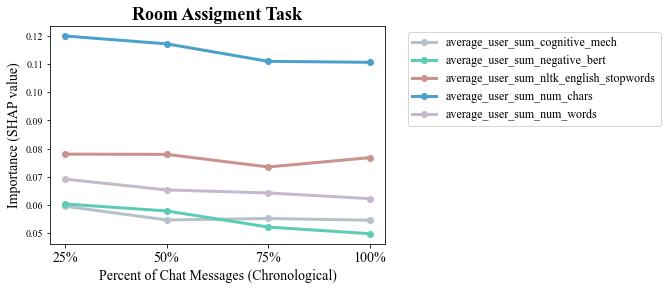

In [32]:
#csop_shap_means, csop_shap_cor_means, csop_train_means, csop_test_means
merged_df = pd.concat([csop_shap_means25, csop_shap_means50, csop_shap_means75, csop_shap_means], keys = time_points, axis=1)
plot_important_features_over_time(merged_df, color_mapping, "Room Assigment Task", "./figures/csop_features.svg")

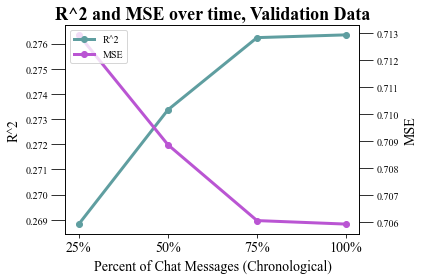

In [33]:
test_metrics = pd.concat([csop_test_means25, csop_test_means50, csop_test_means75, csop_test_means], keys = time_points, axis=1)
plot_r2_and_mse_over_time(test_metrics, "R^2 and MSE over time, Validation Data")

In [68]:
# look at direction of impact
pd.concat([csop_shap_cor_means25, csop_shap_cor_means50, csop_shap_cor_means75, csop_shap_cor_means], keys = time_points, axis=1).head(20)

,25%,50%,75%,100%
feature,,,,
average_user_sum_num_chars,-0.900446,-0.897112,-0.895296,-0.895396
average_user_sum_nltk_english_stopwords,-0.885408,-0.884561,-0.880669,-0.884603
average_user_sum_num_words,-0.782241,-0.787433,-0.786136,-0.790366
average_user_sum_negative_bert,-0.596303,-0.595510,-0.609625,-0.627165
average_user_sum_cognitive_mech,-0.755266,-0.760895,-0.755116,-0.755865
max_user_sum_negative_bert,-0.677538,-0.664857,-0.673230,-0.644027
max_user_sum_num_chars,-0.750400,-0.737480,-0.767430,-0.745170
average_user_sum_neutral_bert,-0.124090,-0.144021,-0.099711,-0.102525
average_user_sum_adverbs,-0.569895,-0.560179,-0.582380,-0.596596


In [69]:
pd.concat([csop_shap_means25, csop_shap_means50, csop_shap_means75, csop_shap_means], keys = time_points, axis=1).head(20)

,25%,50%,75%,100%
feature,,,,
average_user_sum_num_chars,0.120057,0.117261,0.111045,0.110696
average_user_sum_nltk_english_stopwords,0.078043,0.077943,0.073476,0.076779
average_user_sum_num_words,0.069144,0.065294,0.064235,0.062211
average_user_sum_negative_bert,0.060298,0.057822,0.052100,0.049747
average_user_sum_cognitive_mech,0.059501,0.054620,0.055146,0.054527
max_user_sum_negative_bert,0.025550,0.021771,0.019461,0.017594
max_user_sum_num_chars,0.024072,0.021143,0.020380,0.019491
average_user_sum_neutral_bert,0.023851,0.022988,0.020765,0.020941
average_user_sum_adverbs,0.023145,0.022003,0.019916,0.021550


# DAT

### Full data (100%)

In [35]:
dat_model = ModelBuilder(dataset_names = ["dat"])
dat_model.select_target(target=["efficiency"])
dat_model.define_model(model_type = 'rf')

In [36]:
dat_shap, dat_shap_cor, dat_train_metrics, dat_test_metrics = repeated_kfold_cv(dat_model)
dat_shap_means, dat_shap_cor_means, dat_train_means, dat_test_means = get_repeated_kfold_cv_summary(dat_shap, dat_shap_cor, dat_train_metrics, dat_test_metrics)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done


### 75% Data

In [37]:
dat_model75 = ModelBuilder(dataset_names = ["dat"], output_dir = '../output/first_75/')
dat_model75.select_target(target=["efficiency"])
dat_model75.define_model(model_type = 'rf')

In [38]:
dat_shap75, dat_shap_cor75, dat_train_metrics75, dat_test_metrics75 = repeated_kfold_cv(dat_model75)
dat_shap_means75, dat_shap_cor_means75, dat_train_means75, dat_test_means75 = get_repeated_kfold_cv_summary(dat_shap75, dat_shap_cor75, dat_train_metrics75, dat_test_metrics75)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done


### 50% Data

In [39]:
dat_model50 = ModelBuilder(dataset_names = ["dat"], output_dir = '../output/first_50/')
dat_model50.select_target(target=["efficiency"])
dat_model50.define_model(model_type = 'rf')

In [40]:
dat_shap50, dat_shap_cor50, dat_train_metrics50, dat_test_metrics50 = repeated_kfold_cv(dat_model50)
dat_shap_means50, dat_shap_cor_means50, dat_train_means50, dat_test_means50 = get_repeated_kfold_cv_summary(dat_shap50, dat_shap_cor50, dat_train_metrics50, dat_test_metrics50)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done


### 25% Data

In [41]:
dat_model25 = ModelBuilder(dataset_names = ["dat"], output_dir = '../output/first_25/')
dat_model25.select_target(target=["efficiency"])
dat_model25.define_model(model_type = 'rf')

In [42]:
dat_shap25, dat_shap_cor25, dat_train_metrics25, dat_test_metrics25 = repeated_kfold_cv(dat_model25)
dat_shap_means25, dat_shap_cor_means25, dat_train_means25, dat_test_means25 = get_repeated_kfold_cv_summary(dat_shap25, dat_shap_cor25, dat_train_metrics25, dat_test_metrics25)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done


### Combine DAT Results

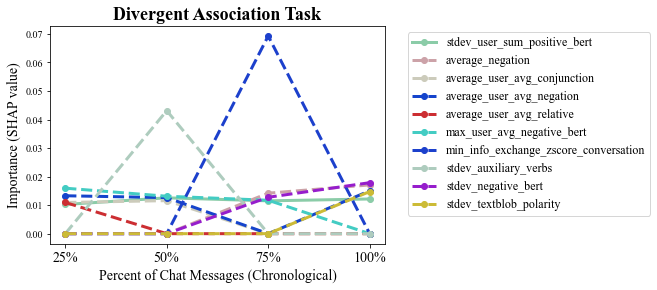

In [43]:
merged_df = pd.concat([dat_shap_means25, dat_shap_means50, dat_shap_means75, dat_shap_means], keys = time_points, axis=1)
plot_important_features_over_time(merged_df, color_mapping, "Divergent Association Task", "./figures/dat_features.svg")

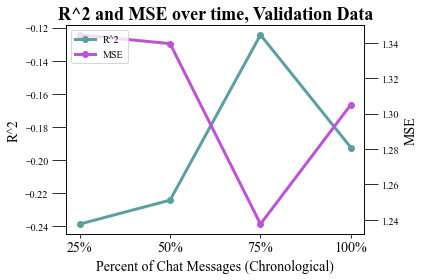

In [44]:
test_metrics = pd.concat([dat_test_means25, dat_test_means50, dat_test_means75, dat_test_means], keys = time_points, axis=1)
plot_r2_and_mse_over_time(test_metrics, "R^2 and MSE over time, Validation Data")

In [45]:
# look at direction of impact
pd.concat([dat_shap_cor_means25, dat_shap_cor_means50, dat_shap_cor_means75, dat_shap_cor_means], keys = time_points, axis=1).head(10)

,25%,50%,75%,100%
feature,,,,
max_user_avg_negative_bert,-0.684372,-0.729244,-0.732973,-0.652701
average_user_avg_negation,0.827237,0.781352,0.773995,0.815701
average_user_avg_relative,-0.407942,-0.429641,-0.489017,-0.575055
average_user_avg_conjunction,-0.320532,-0.569314,-0.595497,-0.335726
stdev_user_sum_positive_bert,-0.201204,-0.406756,-0.286033,-0.156210
average_user_sum_negation,0.729727,0.648918,0.767429,0.744702
stdev_user_sum_textblob_subjectivity,0.229651,-0.328191,0.008992,-0.052419
average_user_sum_percept,-0.724377,-0.736571,-0.588501,-0.696917
stdev_user_sum_positive_affect,-0.750329,-0.636458,-0.740893,-0.520682


# Estimation

### Full Data (100%)

In [46]:
estimation_blended_model = ModelBuilder(dataset_names = ["gurcay", "becker"])
estimation_blended_model.select_target(target=["mean_post_discussion_error_pct", "mean_post_discussion_error_pct"])
estimation_blended_model.define_model(model_type = 'rf')

In [47]:
estimation_shap, estimation_shap_cor, estimation_train_metrics, estimation_test_metrics = repeated_kfold_cv(estimation_blended_model)
estimation_shap_means, estimation_shap_cor_means, estimation_train_means, estimation_test_means = get_repeated_kfold_cv_summary(estimation_shap, estimation_shap_cor, estimation_train_metrics, estimation_test_metrics)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done


### 75% Data

In [48]:
estimation_blended_model75 = ModelBuilder(dataset_names = ["gurcay", "becker"],  output_dir = '../output/first_75/')
estimation_blended_model75.select_target(target=["mean_post_discussion_error_pct", "mean_post_discussion_error_pct"])
estimation_blended_model75.define_model(model_type = 'rf')

In [49]:
estimation_shap75, estimation_shap_cor75, estimation_train_metrics75, estimation_test_metrics75 = repeated_kfold_cv(estimation_blended_model75)
estimation_shap_means75, estimation_shap_cor_means75, estimation_train_means75, estimation_test_means75 = get_repeated_kfold_cv_summary(estimation_shap75, estimation_shap_cor75, estimation_train_metrics75, estimation_test_metrics75)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done


### 50% Data

In [50]:
estimation_blended_model50 = ModelBuilder(dataset_names = ["gurcay", "becker"],  output_dir = '../output/first_50/')
estimation_blended_model50.select_target(target=["mean_post_discussion_error_pct", "mean_post_discussion_error_pct"])
estimation_blended_model50.define_model(model_type = 'rf')

In [51]:
estimation_shap50, estimation_shap_cor50, estimation_train_metrics50, estimation_test_metrics50 = repeated_kfold_cv(estimation_blended_model50)
estimation_shap_means50, estimation_shap_cor_means50, estimation_train_means50, estimation_test_means50 = get_repeated_kfold_cv_summary(estimation_shap50, estimation_shap_cor50, estimation_train_metrics50, estimation_test_metrics50)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done


### 25% Data

In [52]:
estimation_blended_model25 = ModelBuilder(dataset_names = ["gurcay", "becker"],  output_dir = '../output/first_25/')
estimation_blended_model25.select_target(target=["mean_post_discussion_error_pct", "mean_post_discussion_error_pct"])
estimation_blended_model25.define_model(model_type = 'rf')

In [53]:
estimation_shap25, estimation_shap_cor25, estimation_train_metrics25, estimation_test_metrics25 = repeated_kfold_cv(estimation_blended_model25)
estimation_shap_means25, estimation_shap_cor_means25, estimation_train_means25, estimation_test_means25 = get_repeated_kfold_cv_summary(estimation_shap25, estimation_shap_cor25, estimation_train_metrics25, estimation_test_metrics25)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done


### Combine Estimation Results

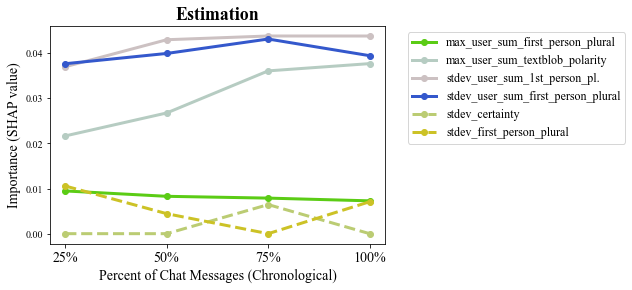

In [54]:
merged_df = pd.concat([estimation_shap_means25, estimation_shap_means50, estimation_shap_means75, estimation_shap_means], keys = time_points, axis=1)
plot_important_features_over_time(merged_df, color_mapping, "Estimation", "./figures/estimation_features.svg")

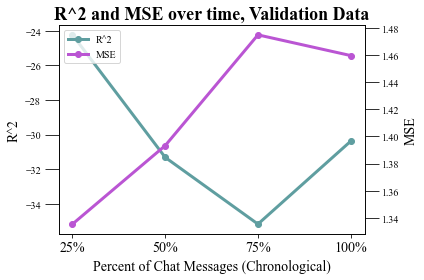

In [55]:
test_metrics = pd.concat([estimation_test_means25, estimation_test_means50, estimation_test_means75, estimation_test_means], keys = time_points, axis=1)
plot_r2_and_mse_over_time(test_metrics, "R^2 and MSE over time, Validation Data")

In [79]:
# look at direction of impact
pd.concat([estimation_shap_cor_means25,estimation_shap_cor_means50, estimation_shap_cor_means75, estimation_shap_cor_means], keys = time_points, axis=1).head(10)

,25%,50%,75%,100%
feature,,,,
stdev_user_sum_first_person_plural,0.401000,0.393266,0.528922,0.452977
stdev_user_sum_1st_person_pl.,0.498827,0.458833,0.363797,0.426298
max_user_sum_textblob_polarity,0.123931,0.311566,0.249594,0.192662
stdev_first_person_plural,0.363034,0.001113,0.266368,0.281889
max_user_sum_first_person_plural,0.270609,0.295551,0.359164,0.282529
average_first_person_plural,0.357078,0.060374,0.462882,0.448753
max_positive_affect,-0.140098,-0.127752,-0.337606,NaN
max_first_person_plural,-0.024793,NaN,NaN,0.001517
average_user_sum_first_person_plural,0.530834,0.453890,0.362392,0.364181


### Combine Metrics into Single Image

In [81]:
jury_metrics = pd.concat([jury_test_means25, jury_test_means50, jury_test_means75, jury_test_means], keys = time_points, axis=1) 
csop_metrics = pd.concat([csop_test_means25, csop_test_means50, csop_test_means75, csop_test_means], keys = time_points, axis=1)
dat_metrics = pd.concat([dat_test_means25, dat_test_means50, dat_test_means75, dat_test_means], keys = time_points, axis=1)
estimation_metrics = pd.concat([estimation_test_means25, estimation_test_means50, estimation_test_means75, estimation_test_means], keys = time_points, axis=1)

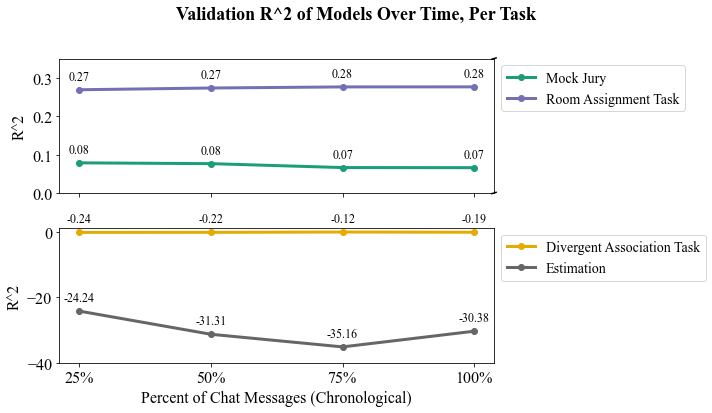

In [58]:
def plot_r2_with_broken_axis(datasets, dataset_names, title):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6))

    plt.style.use({"figure.facecolor": "white", "axes.facecolor": "white"})

    # Define line styles and colors from Dark2 colormap
    num_colors = len(dataset_names)
    colors = mpl.cm.Dark2(np.linspace(0, 1, num_colors))

    # Plot positive datasets on ax1
    for i, dataset in enumerate([jury_metrics, csop_metrics]):
        dataset_name = dataset_names[i]
        transposed_data = dataset.T

        # Create the left y-axis for R^2 on the first plot
        ax1.plot(time_points, transposed_data["r2"], marker='o', label=dataset_name, color=colors[i], linewidth=3)
        for x, y in zip(time_points, transposed_data["r2"]):
            ax1.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12)

    # Set limits for ax1
    ax1.set_ylim(-0, 0.35)  # Adjust the limits as needed

    # Plot negative datasets on ax2
    for i, dataset in enumerate([dat_metrics, estimation_metrics]):
        j = i+2 #MESSY -- but this is manually set to the negative datasets (DAT, Estimation), and assumes they are the last 2 in the list
        dataset_name = dataset_names[j] 
        transposed_data = dataset.T

        # Create the left y-axis for R^2 on the first plot
        ax2.plot(time_points, transposed_data["r2"], marker='o', label=dataset_name, color=colors[j], linewidth=3)
        for x, y in zip(time_points, transposed_data["r2"]):
            ax2.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12)

    # Set limits for ax2
    ax2.set_ylim(-40, 1)  # Adjust the limits as needed

    # Remove the space between the two plots
    plt.subplots_adjust(hspace=0)

    # Adjust layout and labels
    ax1.tick_params(axis="both", labelsize=16)  # Increase tick label size
    ax2.tick_params(axis="both", labelsize=16)  # Increase tick label size
    ax1.set_ylabel("R^2", fontsize=16)
    ax2.set_ylabel("R^2", fontsize=16)
    ax2.set_xlabel("Percent of Chat Messages (Chronological)", fontsize=16)

    # Move the legend to the right
    lines, labels = ax1.get_legend_handles_labels()
    ax1.legend(lines, labels, loc="upper left", fontsize=14, bbox_to_anchor=(1, 1.005))  # Adjust the y-coordinate
    lines, labels = ax2.get_legend_handles_labels()
    ax2.legend(lines, labels, loc="upper left", fontsize=14, bbox_to_anchor=(1, 1.005))

    # Add broken y-axis symbol
    d = .005  # Offset for markings
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((1-d,1+d), (-d,+d), **kwargs)
    ax1.plot((1-d,1+d),(1-d,1+d), **kwargs)

    # Adjust title position to the top
    plt.suptitle(title, fontweight="bold", fontsize=18)

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('./figures/validation_test_r2_graph.svg', dpi=1200, bbox_inches='tight')
    plt.show()

datasets = [jury_metrics, csop_metrics, dat_metrics, estimation_metrics]
dataset_names = ["Mock Jury", "Room Assignment Task", "Divergent Association Task", "Estimation"]

plot_r2_with_broken_axis(datasets, dataset_names, "Validation R^2 of Models Over Time, Per Task")


In [80]:
jury_metrics = pd.concat([jury_train_means25, jury_train_means50, jury_train_means75, jury_train_means], keys = time_points, axis=1) 
csop_metrics = pd.concat([csop_train_means25, csop_train_means50, csop_train_means75, csop_train_means], keys = time_points, axis=1)
dat_metrics = pd.concat([dat_train_means25, dat_train_means50, dat_train_means75, dat_train_means], keys = time_points, axis=1)
estimation_metrics = pd.concat([estimation_train_means25, estimation_train_means50, estimation_train_means75, estimation_train_means], keys = time_points, axis=1)

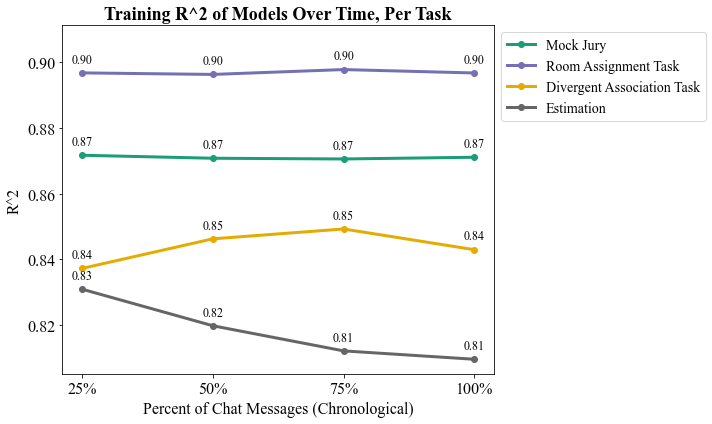

In [60]:
def plot_r2_without_broken_axis(datasets, dataset_names, title):
    fig, ax = plt.subplots(figsize=(10, 6))

    plt.style.use({"figure.facecolor": "white", "axes.facecolor": "white"})

    # Define line styles and colors from Dark2 colormap
    num_colors = len(dataset_names)
    colors = mpl.cm.Dark2(np.linspace(0, 1, num_colors))

    # Plot datasets on the same y-axis
    for i, dataset in enumerate(datasets):
        dataset_name = dataset_names[i]
        transposed_data = dataset.T

        # Plot R^2 values for each dataset
        ax.plot(time_points, transposed_data["r2"], marker='o', label=dataset_name, color=colors[i], linewidth=3)
        for x, y in zip(time_points, transposed_data["r2"]):
            ax.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12)

    # Adjust layout and labels
    ax.tick_params(axis="both", labelsize=16)  # Increase tick label size
    ax.set_ylabel("R^2", fontsize=16)
    ax.set_xlabel("Percent of Chat Messages (Chronological)", fontsize=16)

    # Add legend to the right
    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines, labels, loc="upper left", fontsize=14, bbox_to_anchor=(1, 1))

    # Set y-axis range with a buffer
    ax.set_ylim(min(ax.get_ylim()), max(ax.get_ylim())*1.01)

    # Adjust title position
    plt.title(title, fontweight="bold", fontsize=18)

    # Adjust layout
    plt.tight_layout()
    plt.savefig('./figures/train_r2_graph.svg', dpi=1200, bbox_inches='tight')
    plt.show()

# Assuming you have defined the four datasets and their names as you described
datasets = [jury_metrics, csop_metrics, dat_metrics, estimation_metrics]
dataset_names = ["Mock Jury", "Room Assignment Task", "Divergent Association Task", "Estimation"]

# Call the function to plot R^2 values without broken y-axis
plot_r2_without_broken_axis(datasets, dataset_names, "Training R^2 of Models Over Time, Per Task")


In [74]:
def plot_histogram(dataframe, column_name, path):
    # Extract the data from the specified column
    data = dataframe[column_name]

    # Create a histogram
    plt.hist(data, bins=10, color='blue', alpha=0.7)
    
    # Customize the plot
    #plt.title(f'Histogram of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')

    plt.savefig(path)

    # Show the plot
    plt.show()

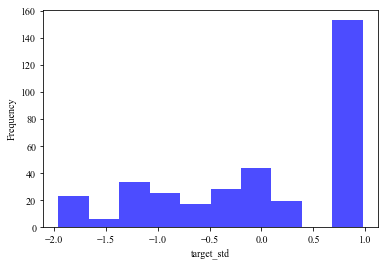

In [75]:
plot_histogram(juries_model.conv, 'target_std', './figures/juries_dv_distribution.svg')

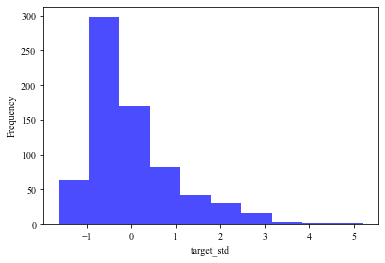

In [76]:
plot_histogram(csop_blended_model.conv, 'target_std', './figures/csop_dv_distribution.svg')

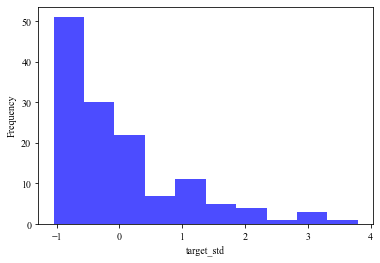

In [77]:
plot_histogram(dat_model.conv, 'target_std', './figures/dat_dv_distribution.svg')

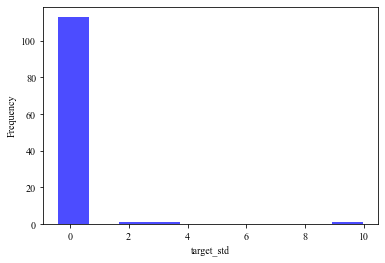

In [78]:
plot_histogram(estimation_blended_model.conv, 'target_std', './figures/estimation_dv_distribution.svg')

# Create a PCA plot of the conversation features, colored by task

In [199]:
juries_data = pd.read_csv('../output/jury_output_conversation_level.csv')
csop_data = pd.read_csv('../output/csop_output_conversation_level.csv')
csopII_data = pd.read_csv('../output/csopII_output_conversation_level.csv')
dat_data = pd.read_csv('../output/dat_output_conversation_level.csv')
becker_data = pd.read_csv('../output/beckerestimation_output_conversation_level.csv')
gurcay_data = pd.read_csv('../output/gurcay2015estimation_output_conversation_level.csv')

In [200]:
def drop_non_common_columns(data_frames):
    # Check if there are any data frames in the list
    if not data_frames:
        return []

    # Find the intersection of columns in all data frames
    common_columns = set(data_frames[0].columns)
    for df in data_frames[1:]:
        common_columns = common_columns.intersection(df.columns)

    # Create a new list of data frames with only common columns
    new_data_frames = []
    for df in data_frames:
        new_data_frames.append(df[common_columns])

    return new_data_frames


In [207]:
def get_numeric_cols(dfs):
    new_dfs=[]
    for df in dfs:
        new_dfs.append(df.select_dtypes(['number']))
    return new_dfs

In [201]:
juries_data, csop_data, csopII_data, dat_data, becker_data, gurcay_data = drop_non_common_columns([juries_data, csop_data, csopII_data, dat_data, becker_data, gurcay_data])

csop_blended_data = pd.concat([csop_data,csopII_data], axis=0)
estimation_blended_data = pd.concat([becker_data,gurcay_data], axis=0)

In [209]:
juries_data, csop_blended_data, dat_data, estimation_blended_data = get_numeric_cols([juries_data, csop_blended_data, dat_data, estimation_blended_data])


In [250]:
def plot_pca_of_dataframes(*dfs, labels):
    """
    Plot data from multiple DataFrames on the same 2D PCA plot, coloring by labels.

    Parameters:
    *dfs (pd.DataFrame): Variable-length argument for input DataFrames.
    labels (list): List of labels corresponding to each DataFrame.

    Returns:
    None
    """
    # Add a "task_name" column to each DataFrame based on the corresponding label
    for i, df in enumerate(dfs):
        df['task_name'] = labels[i]
    
    # Concatenate the DataFrames into a single DataFrame
    stacked_data = stacked_data = pd.concat([df.assign(task_name=labels[i]) for i, df in enumerate(dfs)], axis=0)
    
    # Drop rows with any NaN values
    stacked_data = stacked_data.dropna(axis=1)

    # Perform PCA for dimensionality reduction (2 components for 2D)
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(stacked_data.drop(columns=['task_name']))

    # Create a scatter plot and use the "task_name" column for coloring
    plt.figure(figsize=(10, 6))
    unique_labels = list(set(labels))
    colors = plt.cm.Dark2(np.arange(len(unique_labels)))

    for i, label in enumerate(unique_labels):
        label_data = reduced_data[stacked_data['task_name'] == label]
        plt.scatter(label_data[:, 0], label_data[:, 1], label=label, color=colors[i], alpha=0.6)

    plt.title("PCA Plot of DataFrames")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(loc='best', title='Task')
    plt.grid(True)
    plt.show()

In [245]:
def check_na_rows_cols(df):
    # Check for NaN values in columns
    nan_columns = df.columns[df.isna().any()].tolist()

    # Check for NaN values in rows
    nan_rows = df.index[df.isna().any(axis=1)].tolist()

    # Display the columns and rows with NaN values
    print("Columns with NaN values:", nan_columns)
    print("Rows with NaN values:", nan_rows)

In [237]:
check_na_rows_cols(juries_data)

Columns with NaN values: []
Rows with NaN values: []


In [238]:
check_na_rows_cols(dat_data)

Columns with NaN values: ['stdev_user_avg_positivity_zscore_conversation', 'min_user_avg_positivity_zscore_conversation', 'average_info_exchange_zscore_conversation', 'min_info_exchange_zscore_conversation', 'stdev_info_exchange_zscore_conversation', 'stdev_positivity_zscore_conversation', 'max_user_avg_positivity_zscore_conversation', 'max_user_avg_info_exchange_zscore_conversation', 'average_positivity_zscore_conversation', 'average_user_avg_info_exchange_zscore_conversation', 'max_positivity_zscore_conversation', 'max_info_exchange_zscore_conversation', 'average_user_avg_positivity_zscore_conversation', 'min_positivity_zscore_conversation', 'stdev_user_avg_info_exchange_zscore_conversation', 'min_user_avg_info_exchange_zscore_conversation']
Rows with NaN values: [5, 9, 35, 42, 43, 44, 49, 54, 60, 61, 62, 63, 64, 69, 78, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 93, 94, 97, 98, 99, 100, 105, 111, 112, 113, 114, 115, 126, 130, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 

In [239]:
check_na_rows_cols(estimation_blended_data)

Columns with NaN values: []
Rows with NaN values: []


In [220]:
check_na_rows_cols(csop_blended_data)

Columns with NaN values: ['stdev_user_avg_positivity_zscore_conversation', 'min_user_avg_positivity_zscore_conversation', 'average_info_exchange_zscore_conversation', 'min_info_exchange_zscore_conversation', 'stdev_info_exchange_zscore_conversation', 'gini_coefficient_sum_num_chars', 'stdev_positivity_zscore_conversation', 'max_user_avg_positivity_zscore_conversation', 'max_user_avg_info_exchange_zscore_conversation', 'average_positivity_zscore_conversation', 'average_user_avg_info_exchange_zscore_conversation', 'max_positivity_zscore_conversation', 'max_info_exchange_zscore_conversation', 'average_user_avg_positivity_zscore_conversation', 'min_positivity_zscore_conversation', 'stdev_user_avg_info_exchange_zscore_conversation', 'min_user_avg_info_exchange_zscore_conversation', 'gini_coefficient_sum_num_words']
Rows with NaN values: [10, 11, 12, 15, 16, 18, 19, 20, 21, 22, 23, 24, 29, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 48, 49, 51, 53, 54, 55, 56, 57, 58, 60, 61, 62, 63, 64, 68,

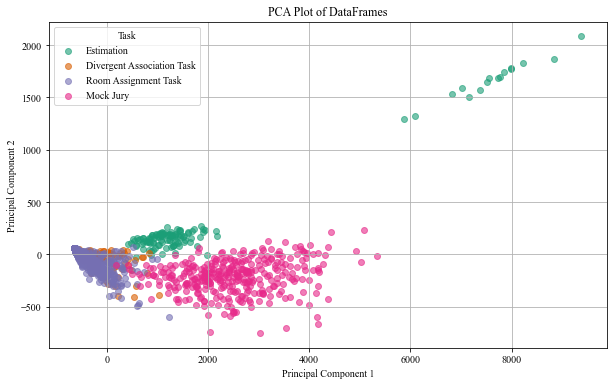

In [251]:
plot_pca_of_dataframes(juries_data, csop_blended_data, dat_data, estimation_blended_data, labels=labels)